# Visualizing Hyper Parameters Search

## Global Parameters

In [1]:
random_seed = 20210914

## Load Data

In [2]:
import statsmodels.api as sm

In [3]:
dataset = sm.datasets.get_rdataset("Affairs", package="AER").data
dataset

,affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
4,0,male,37.0,10.00,no,3,18,7,4
5,0,female,27.0,4.00,no,4,14,6,4
11,0,female,32.0,15.00,yes,1,12,1,4
16,0,male,57.0,15.00,yes,5,18,6,5
23,0,male,22.0,0.75,no,2,17,6,3
...,...,...,...,...,...,...,...,...,...
1938,1,male,22.0,1.50,yes,1,12,2,5
1941,7,female,32.0,10.00,yes,2,18,5,4
1954,2,male,32.0,10.00,yes,2,17,6,5
1959,2,male,22.0,7.00,yes,3,18,6,2


In [4]:
target_column = "affairs"
feature_columns = dataset.columns.drop(target_column)

target_data = dataset[target_column]
feature_data = dataset[feature_columns]

## Feature Engineering

In [5]:
from sklearn.preprocessing import OrdinalEncoder

In [6]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601 entries, 4 to 9010
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         601 non-null    object 
 1   age            601 non-null    float64
 2   yearsmarried   601 non-null    float64
 3   children       601 non-null    object 
 4   religiousness  601 non-null    int64  
 5   education      601 non-null    int64  
 6   occupation     601 non-null    int64  
 7   rating         601 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 42.3+ KB


In [7]:
categorical_features = feature_data.select_dtypes(exclude=["float64", "int64"])
categorical_features.head()

,gender,children
4,male,no
5,female,no
11,female,yes
16,male,yes
23,male,no


In [8]:
encoder = OrdinalEncoder()
categorical_features_encoded = encoder.fit_transform(categorical_features)
categorical_features_encoded

array([[1., 0.],
       [0., 0.],
       [0., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [0., 1.]])

In [9]:
feature_data.loc[:, categorical_features.columns] = categorical_features_encoded

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [10]:
feature_data.head()

,gender,age,yearsmarried,children,religiousness,education,occupation,rating
4,1.0,37.0,10.00,0.0,3,18,7,4
5,0.0,27.0,4.00,0.0,4,14,6,4
11,0.0,32.0,15.00,1.0,1,12,1,4
16,1.0,57.0,15.00,1.0,5,18,6,5
23,1.0,22.0,0.75,0.0,2,17,6,3


## Train Clasifier

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [12]:
classifier = DecisionTreeClassifier(random_state=random_seed)
cross_validation = StratifiedKFold(15)

metrics = cross_val_score(classifier, feature_data, target_data, cv=cross_validation)

## Compute Performance

In [13]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(random_seed)

In [14]:
plt.rcParams["figure.figsize"] = 16, 4
plt.style.use("bmh")

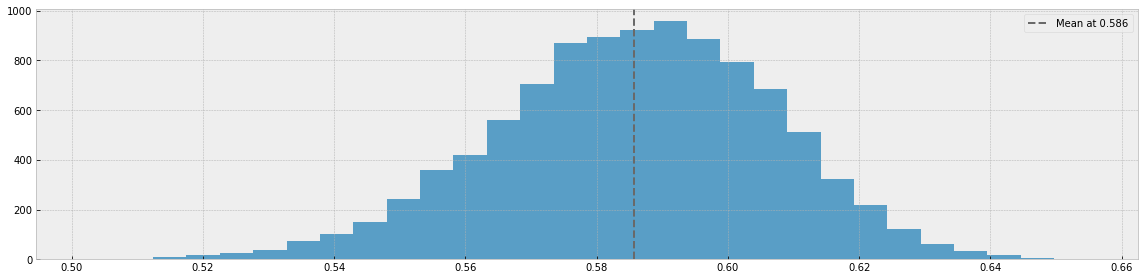

In [15]:
bootstrapped = np.random.choice(metrics, size=(len(metrics), 10_000))
bootstrapped_jittered = bootstrapped + np.random.normal(0, 0.01, size=bootstrapped.shape)
bootstrapped_means = bootstrapped_jittered.mean(axis=0)

plt.hist(bootstrapped_means, alpha=0.8, bins=30)
mean_of_means = bootstrapped_means.mean()
plt.axvline(mean_of_means, ls="--", color="dimgrey", label=f"Mean at {mean_of_means:.3f}")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
f"Probability of getting Accuracy greater than 0.75: {np.mean(bootstrapped_means > 0.75):.4f}"

'Probability of getting Accuracy greater than 0.75: 0.0000'

## Hyperparameter Search

In [17]:
import wandb

from sklearn.model_selection import ParameterGrid

from tqdm.notebook import tqdm

In [18]:
params = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None, 1, 5, 20, 50, 100, 500],
    "min_samples_split": [2, 4, 8, 16, 32],
    "min_samples_leaf": [1, 2, 4, 8, 16, 32],
    "min_weight_fraction_leaf": [0, 0.01, 0.05, 0.1],
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 5, 20, 50, 100],
    "min_impurity_decrease": [0],
    "ccp_alpha": [0, 0.01, 0.05],
    "random_state": [random_seed],
}

parameter_grid = ParameterGrid(params)

len(parameter_grid)

100800

In [ ]:
cross_validation = StratifiedKFold(15)
combinations = 500

for index, parameter_set in tqdm(enumerate(parameter_grid, start=1), total=combinations):
    run = wandb.init(project="DiplomaturaDS", reinit=True)

    run.config["DEVICE"] = "LAPTOP"
    run.config["FRAMEWORK"] = "SCIKIT-LEARN"
    run.config.update(parameter_set)

    classifier = DecisionTreeClassifier(**parameter_set)

    metrics = cross_val_score(classifier, 
                              feature_data, 
                              target_data, 
                              cv=cross_validation)

    run.log({"accuracy": metrics.mean()})
    
    run.finish()

    if index >= combinations:
        break

  0%|          | 0/500 [00:00<?, ?it/s]

wandb: Currently logged in as: elc (use `wandb login --relogin` to force relogin)


accuracy,0.60398
_runtime,12
_timestamp,1631585034
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.61415
_runtime,10
_timestamp,1631585093
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.74045
_runtime,10
_timestamp,1631585160
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.74207
_runtime,12
_timestamp,1631585218
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,9
_timestamp,1631585268
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,11
_timestamp,1631585323
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,8
_timestamp,1631585369
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,10
_timestamp,1631585417
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.6839
_runtime,10
_timestamp,1631585492
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.65569
_runtime,12
_timestamp,1631585552
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.74045
_runtime,13
_timestamp,1631585633
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.74207
_runtime,13
_timestamp,1631585717
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,11
_timestamp,1631585790
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,11
_timestamp,1631585845
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,9
_timestamp,1631585909
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,11
_timestamp,1631585953
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.70715
_runtime,11
_timestamp,1631586000
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.71215
_runtime,10
_timestamp,1631586047
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.74045
_runtime,11
_timestamp,1631586096
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.74207
_runtime,10
_timestamp,1631586140
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,10
_timestamp,1631586190
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,13
_timestamp,1631586237
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


accuracy,0.75041
_runtime,8
_timestamp,1631586277
_step,0


accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁
